# Web scraping with BeautifulSoup 

this demo shows how to use BeautifulSoup to crawl job listing in Indeed

In [1]:
## import necessary packaeges
from bs4 import BeautifulSoup
import urllib
import re
import pandas as pd
from nltk import word_tokenize
from nltk.corpus import stopwords
import string
import numpy as np
import matplotlib.pyplot as plt
import nltk
from collections import Counter
%matplotlib inline

## 1.Reach the link of jobs first 

use indeed mobile web version since its html is simplier

In [2]:
from urllib.request import urlopen
url = "https://www.indeed.com/m/jobs?q=data+scientist&l="
page = urlopen(url)
soup = BeautifulSoup(page)

all_matches = soup.find_all('a',attrs={'rel':['nofollow']})

for i in all_matches:
    print(i['href'])
    print(type(i['href']))
    print("https://www.indeed.com/m/"+i['href'])

viewjob?jk=314ea15d9490b1ca
<class 'str'>
https://www.indeed.com/m/viewjob?jk=314ea15d9490b1ca
viewjob?jk=73ed58146bf46032
<class 'str'>
https://www.indeed.com/m/viewjob?jk=73ed58146bf46032
viewjob?jk=93d36f861d85a9af
<class 'str'>
https://www.indeed.com/m/viewjob?jk=93d36f861d85a9af
viewjob?jk=5ff80403645bb46e
<class 'str'>
https://www.indeed.com/m/viewjob?jk=5ff80403645bb46e
viewjob?jk=c16a77f01d5e992c
<class 'str'>
https://www.indeed.com/m/viewjob?jk=c16a77f01d5e992c
viewjob?jk=1e686166d30fd118
<class 'str'>
https://www.indeed.com/m/viewjob?jk=1e686166d30fd118
viewjob?jk=284b64515c71fda0
<class 'str'>
https://www.indeed.com/m/viewjob?jk=284b64515c71fda0
viewjob?jk=6c7cca2d0fb68a93
<class 'str'>
https://www.indeed.com/m/viewjob?jk=6c7cca2d0fb68a93
viewjob?jk=267e7cf7de2959c7
<class 'str'>
https://www.indeed.com/m/viewjob?jk=267e7cf7de2959c7
viewjob?jk=8ce98c9bedd5295f
<class 'str'>
https://www.indeed.com/m/viewjob?jk=8ce98c9bedd5295f


### 2.Find the title, company, location and detailed job description for each job 

In [3]:
test_html = \
'''
<html>
	<body>
		<p>
			<b>
				<font size='+1'>Analyst -Data Scientist</font>
			</b>
			<br>The Boston Consulting Group -<span class="location">Los Angeles,CA</span>
		</p>
	</body>
</html>
'''


In [4]:
bs = BeautifulSoup(test_html,'lxml')

In [5]:
print(bs.body.p.b.font.text)

Analyst -Data Scientist


In [6]:
print(bs.body.p.text)



Analyst -Data Scientist

The Boston Consulting Group -Los Angeles,CA



In [7]:
print(bs.body.p.span.text)

Los Angeles,CA


#### Find title, company, location and job description for one postion

In [8]:
title = []
company =[]
location =[]
jd = []
salary_lower =[]
salary_upper =[]
for each in all_matches:
    jd_url = 'http://www.indeed.com/m/'+each['href']
    jd_page = urlopen(jd_url)
    jd_soup = BeautifulSoup(jd_page,'lxml')
    jd_desc = jd_soup.findAll('div',attrs={'id':['desc']})
    title.append(jd_soup.body.p.b.font.text)
    company.append(jd_desc[0].span.text)
    location.append(jd_soup.body.p.span.text)
    jd.append(jd_desc[0].text)
    if(re.search('\$(\d+\,\d+)',jd_soup.body.p.text)):
        salary_lower.append(int(re.search('\$(\d+\,\d+)',jd_soup.body.p.text)[1].replace(',','')))
    else:
        salary_lower.append(None)
    if(re.search('\-\s\$(\d+\,\d+)',jd_soup.body.p.text)):
        salary_upper.append(int(re.search('\-\s\$(\d+\,\d+)',jd_soup.body.p.text)[1].replace(',','')))
    else:
        salary_upper.append(None)
    
    

### Saved the data into Data Frame

In [9]:
job = {'title':title,
      'company':company,
      'location':location,
      'Job Description':jd,
      'salary_lower':salary_lower,
      'salary_upper':salary_upper}
df = pd.DataFrame.from_dict(job)

In [10]:
df

,title,company,location,Job Description,salary_lower,salary_upper
0,Data Scientist,Alpha Capital Partners LLC,"Houston, TX 77084",Alpha Capital Partners is a leading middle-mar...,NaN,NaN
1,Sr. Data Analyst,3 days ago,"New Orleans, LA",Primary Talent Partners is a staffing organiza...,NaN,NaN
2,Data Classification Specialist,Idiomatic,"St. Louis, MO","Today, we live in an experience economy where ...",NaN,NaN
3,Data Scientist,Skylight,Remote,Skylight (https://skylight.digital/) is at the...,130000.0,165000.0
4,Data Scientist,6 hours ago,"Memphis, TN","Dear Partner,We have an opportunity for Data S...",NaN,NaN
5,Entry Level - Associate Data Scientist,IBM,United States,"Introduction\nAs a Data Scientist at IBM, you ...",NaN,NaN
6,Data Scientist-Remote,SemanticBits,Remote,SemanticBits is looking for a Data Scientist e...,NaN,NaN
7,Junior Data Scientist - New York City,23 days ago,"New York, NY 10001",Are you a Junior Data Scientist with experienc...,80000.0,120000.0
8,Entry Level Data Scientist,IBM,United States,Introduction\nAt IBM we have an amazing opport...,NaN,NaN
9,Data Scientist/Specialist,BBVA Compass,"Houston, TX",Company: Compass Bank dba BBVA Compass\nLocati...,NaN,NaN


## 3. Change Pages Automatically

In [11]:
title =[]
company =[]
location =[]
jd =[]
salary_lower =[]
salary_upper =[]
url = "https://www.indeed.com/m/jobs?q=data+scientist&l="

#Loop for 50 pages
for i in range(50):
    
    page = urlopen(url)
    soup = BeautifulSoup(page)
    all_matches = soup.findAll(attrs={'rel':['nofollow']})
    for each in all_matches:
        jd_url = "https://www.indeed.com/m/" + each['href']
        jd_page = urlopen(jd_url)
        jd_soup = BeautifulSoup(jd_page,'lxml')
        jd_desc = jd_soup.findAll(attrs={'id':['desc']})
        title.append(jd_soup.body.p.b.font.text)
        company.append(jd_desc[0].span.text)
        location.append(jd_soup.body.p.span.text)
        jd.append(jd_desc[0].text)

        if(re.search('\$\d+\,\d+',jd_soup.body.p.text)):
            salary_lower.append(int(re.search('\$(\d+\,\d+)',jd_soup.body.p.text)[1].replace(',','')))
        else:
            salary_lower.append(None)
        if(re.search('\-\s\$(\d+\,\d+)',jd_soup.body.p.text)):
            salary_upper.append(int(re.search('\-\s\$(\d+\,\d+)',jd_soup.body.p.text)[1].replace(',','')))
        else:
            salary_upper.append(None)  
        
    #change the page to Next
    url_all = soup.findAll(attrs={'rel':['next']})
    url = 'http://www.indeed.com/m/'+ str(url_all[0]['href'])

In [12]:
job = {'title':title,
      'company':company,
      'location':location,
      'jd':jd,
      'salary_lower':salary_lower,
      'salary_upper':salary_upper}
df = pd.DataFrame.from_dict(job)

In [13]:
df.head(50)

,title,company,location,jd,salary_lower,salary_upper
0,Data Scientist,Alpha Capital Partners LLC,"Houston, TX 77084",Alpha Capital Partners is a leading middle-mar...,NaN,NaN
1,Sr. Data Analyst,3 days ago,"New Orleans, LA",Primary Talent Partners is a staffing organiza...,NaN,NaN
2,Data Classification Specialist,Idiomatic,"St. Louis, MO","Today, we live in an experience economy where ...",NaN,NaN
3,Data Scientist,Skylight,Remote,Skylight (https://skylight.digital/) is at the...,130000.0,165000.0
4,Data Scientist,6 hours ago,"Memphis, TN","Dear Partner,We have an opportunity for Data S...",NaN,NaN
5,Entry Level - Associate Data Scientist,IBM,United States,"Introduction\nAs a Data Scientist at IBM, you ...",NaN,NaN
6,Data Scientist-Remote,SemanticBits,Remote,SemanticBits is looking for a Data Scientist e...,NaN,NaN
7,Junior Data Scientist - New York City,23 days ago,"New York, NY 10001",Are you a Junior Data Scientist with experienc...,80000.0,120000.0
8,Entry Level Data Scientist,IBM,United States,Introduction\nAt IBM we have an amazing opport...,NaN,NaN
9,Data Scientist/Specialist,BBVA Compass,"Houston, TX",Company: Compass Bank dba BBVA Compass\nLocati...,NaN,NaN


## 4. Salary Distribution

In [14]:
salary_lower = [ i for i in df['salary_lower'].dropna()]
print("Lower boundary counts: " + str(len(salary_lower)))
salary_upper = [i for i in df['salary_upper'].dropna()]
print("Upper boundary counts: " + str(len(salary_upper)))
# combined lower & upper boundry salary
salary = salary_lower + salary_upper
print("Cobmined records count: " + str(len(salary)))

Lower boundary counts: 66
Upper boundary counts: 52
Cobmined records count: 118


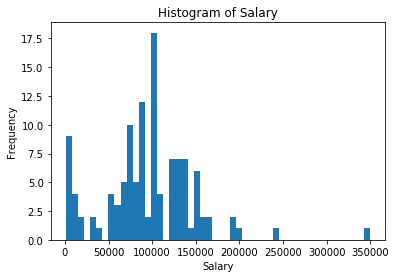

In [15]:
# visualize salary distribution
plt.hist(salary,bins = 50)
plt.title('Histogram of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

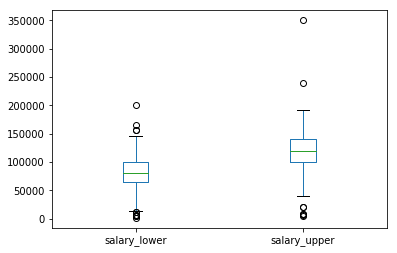

In [16]:
# to visualize the outliers
df.plot(kind='box')

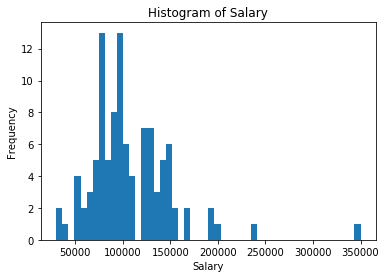

In [17]:
# After verified on the website, the salary below 25000 is monthly salary, the is a plot of the salary range without monthly rate ones
salary = [ i for i in salary if i>25000]
plt.hist(salary,bins = 50)
plt.title('Histogram of Salary')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

## 5. Geology Distribution 

In [18]:
# Remove Zipcode
df['location'] = df['location'].str.replace('\s\d+','')

In [19]:
# Remove City
df['location_state'] = df['location'].str.replace('\w+\,\s','')

In [20]:
np.unique(df['location_state'])

array(['AR', 'AZ', 'Ann MI', 'Annapolis MD', 'Baton LA', 'CA', 'CO', 'CT',
       'Camp HI', 'Carson NV', 'Colorado CO', 'Costa CA', 'Culver CA',
       'DC', 'Daly CA', 'FL', 'Farmers TX', 'Fort TX', 'Foster CA', 'GA',
       'Greenwood CO', 'HI', 'IL', 'Jersey NJ', 'Long CA', 'Los CA',
       'Los NM', 'MA', 'MD', 'MI', 'MN', 'MO', 'Mayfield OH',
       'Melrose IL', 'Menlo CA', 'Minneapolis-Saint MN', 'Monmouth NJ',
       'Morgan CA', 'Mountain CA', 'Mountain OR', 'NC', 'NE', 'NJ', 'NM',
       'NY', 'New LA', 'New NY', 'Newport CA', 'OH', 'OR', 'Offutt NE',
       'PA', 'PR', 'Palo CA', 'RI', 'Redwood CA', 'Remote',
       'Research Triangle NC', 'SC', 'Saint FL', 'Saint MN', 'Saint MO',
       'Salt Lake UT', 'San CA', 'San TX', 'Santa CA', 'Santa Clara CA',
       'South NJ', 'South Sioux NE', 'South UT', 'St. MO',
       'Stennis Space MS', 'TN', 'TX', 'UT', 'United States', 'VA', 'WA',
       'WI', 'West Palm FL'], dtype=object)

In [21]:
# Keep simply type state name
df['location_state'] = df['location_state'].str.replace('\w+\s','')
df['location_state'] = df['location_state'].str.replace('\w+\.\s','')

In [22]:
# Unique locations
unique_location_state = [np.unique(df['location_state'])]
unique_location_state

[array(['AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'HI', 'IL', 'LA',
        'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'Minneapolis-MN', 'NC', 'NE',
        'NJ', 'NM', 'NV', 'NY', 'OH', 'OR', 'PA', 'PR', 'RI', 'Remote',
        'SC', 'States', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI'], dtype=object)]

In [23]:
# Clean state name
df['location_state'] = df['location_state'].str.replace('Texas','TX')
df['location_state'] = df['location_state'].str.replace('Remote','States')
df['location_state'] = df['location_state'].str.replace('Oklahoma','OK')
df['location_state'] = df['location_state'].str.replace('Virginia','VA')
df['location_state'] = df['location_state'].str.replace('Louisiana','LA')
df['location_state'] = df['location_state'].str.replace('California','CA')

In [24]:
unique_location_state = np.unique(df['location_state'])
unique_location_state

array(['AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'HI', 'IL', 'LA',
       'MA', 'MD', 'MI', 'MN', 'MO', 'MS', 'Minneapolis-MN', 'NC', 'NE',
       'NJ', 'NM', 'NV', 'NY', 'OH', 'OR', 'PA', 'PR', 'RI', 'SC',
       'States', 'TN', 'TX', 'UT', 'VA', 'WA', 'WI'], dtype=object)

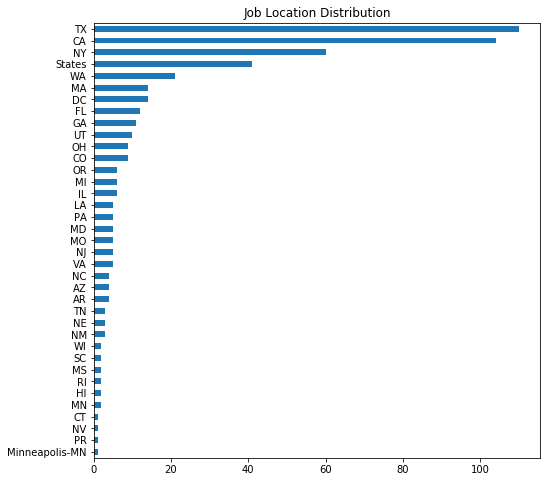

In [25]:
# Visuallize job distribution at each state
df['location_state'].value_counts().sort_values().plot(kind='barh',title='Job Location Distribution',figsize=(8,8))
# TX on top becaused of history cookies and Indeed backend driven

## 6.Top Skills

In [27]:
# gathered all the job descriptions in a string and change into lowercase
jobDescription = ""
for jd in df['jd']:
    jobDescription = jobDescription + "\n" + jd
jobDescription = jobDescription.lower()

jobDescription = re.sub("([^a-z0-9])"," ",jobDescription )

In [29]:
# tokenize the job descriptions
tokens = word_tokenize(jobDescription)

In [31]:
# remove the stop words and puntuations
stop = list(stopwords.words('english') ) + list(string.punctuation)
tokens = [t for t in tokens if t not in stop]

In [32]:
# count the frequency on tokens
token_counts = nltk.FreqDist(tokens)
token_counts.most_common(15)

[('data', 4711),
 ('experience', 1903),
 ('business', 1285),
 ('work', 1224),
 ('science', 1007),
 ('learning', 968),
 ('team', 877),
 ('analysis', 753),
 ('machine', 736),
 ('analytics', 700),
 ('skills', 699),
 ('models', 692),
 ('statistical', 589),
 ('new', 588),
 ('years', 580)]

In [33]:
# BIGRAM
bgs = nltk.bigrams(tokens)

skill_counts = nltk.FreqDist(bgs)
skill_counts.most_common(20)

[(('machine', 'learning'), 715),
 (('data', 'science'), 629),
 (('data', 'scientist'), 455),
 (('days', 'ago'), 392),
 (('computer', 'science'), 258),
 (('data', 'sets'), 217),
 (('years', 'experience'), 204),
 (('data', 'analysis'), 182),
 (('data', 'scientists'), 182),
 (('data', 'mining'), 171),
 (('equal', 'opportunity'), 162),
 (('e', 'g'), 149),
 (('30', 'days'), 147),
 (('experience', 'working'), 146),
 (('sexual', 'orientation'), 142),
 (('national', 'origin'), 141),
 (('experience', 'data'), 137),
 (('2', 'years'), 136),
 (('big', 'data'), 136),
 (('communication', 'skills'), 127)]

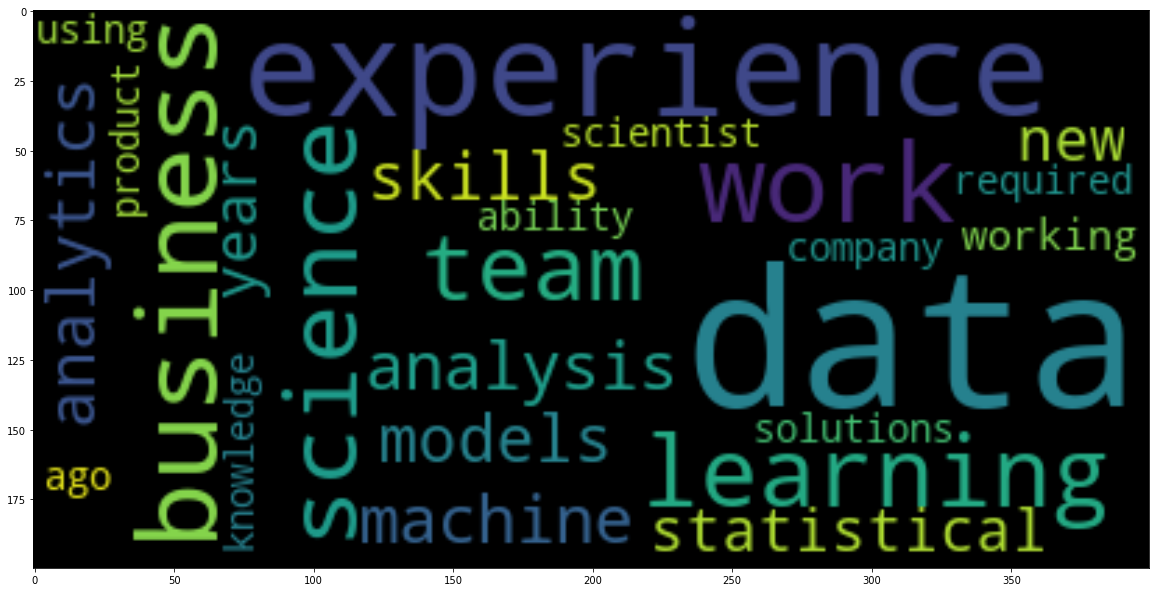

In [34]:
#Visualize top skills
from wordcloud import WordCloud
import matplotlib.pyplot as plt

w = dict(token_counts.most_common(25))

wordcloud = WordCloud()
wordcloud.generate_from_frequencies(w)
plt.figure(figsize=(20,15))
plt.imshow(wordcloud,interpolation="bilinear")
plt.show()